In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row
from astropy.coordinates import SkyCoord


Bad key savefig.frameon in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc

In [44]:
import sys
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts/')
# import mcf
from display import display_merian_cutout_rgb

In [4]:
env_dict = {'project': 'Merian', 'name': '', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/Merian/'

In [5]:
kz.set_matplotlib(style='nature', usetex=False, dpi=80)

In [6]:
obj_cat = Table.read('./Cutout/magellan_spec/magellan_spec_obj_cat.fits')
cutout_cat = Table.read('./Cutout/magellan_spec/magellan_spec-2022-04-20.fits')

obj_cat['prefix'] = cutout_cat['prefix']
obj_cat['dir'] = cutout_cat['dir']
# obj_cat['dir'] = [file.replace('/projects/MERIAN/poststamps/g09_broadcut_new', 
#                               '/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/_new/'
#                              ) for file in obj_cat['dir']]

In [181]:
channels = ['g', 'r', 'i', 'z', 'N708', 'N540']

obj = obj_cat[26] # 64 for slack example
obj_id = obj['id']

cutout = []
for filt in channels:
    if 'N' in filt:
        cutout.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_deepCoadd_calexp.fits")))
    else:
        cutout.append(fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["id"]}_{filt}.fits')))

psf_list = []
for filt in channels:
    if 'N' in filt:
        psf_list.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_psf.fits")))
    else:
        psf_list.append(fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["id"]}_{filt}_psf.fits')))

# Reconstruct data
images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
filters = list(channels)
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
hsc_data = Data(images=images,
                weights=weights,
                wcs=w, psfs=psf_pad, channels=channels)

In [182]:
color_norm = {'g': 1.9, 'r': 1.2, 'i': 1.0,
              'z': 0.85, 'y': 0.5, 'N708': 1.1, 'N540': 1.0}

Text(0.5, 1.0, 'N708')

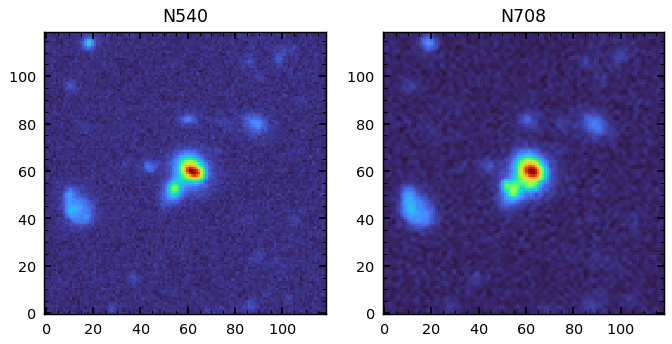

In [200]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(hsc_data.images[2])
ax1.set_title('i')
ax2.imshow(hsc_data.images[-2])
ax2.set_title('N708')

name,ra,dec,PRIORITY,MAG,id,class,redshift,quality,comment,mask,half_size,prefix,dir
,,,,,,,,,,,arcsec,,
int64,float64,float64,int32,float64,int64,bytes16,float64,float64,bytes16,bytes16,float64,bytes20,bytes65
419910,149.72513745041334,1.9338079509179056,100,18.70559740937114,419910,galaxy,0.13200000000000026,2.0,,4089,10.0,magellan_spec_419910,/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/magellan_spec/20/419910
504723,149.5185073871509,2.064788867801468,100,20.163787338027657,504723,galaxy,0.12570000000000026,2.0,,4089,10.0,magellan_spec_504723,/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/magellan_spec/37/504723
646134,149.79627679006242,2.2771740493225687,100,21.280651177248807,646134,galaxy,0.2507999999999988,2.0,,4143,10.0,magellan_spec_646134,/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/magellan_spec/61/646134


In [194]:
obj

name,ra,dec,PRIORITY,MAG,id,class,redshift,quality,comment,mask,half_size,prefix,dir
,,,,,,,,,,,arcsec,,
int64,float64,float64,int32,float64,int64,bytes16,float64,float64,bytes16,bytes16,float64,bytes20,bytes65
316534,149.777920850292,1.766550599664485,100,20.355771074189693,316534,galaxy,0.20299999999999882,2.0,,4089,10.0,magellan_spec_316534,/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/magellan_spec/3/316534


Text(0.5, 1.0, 'HSC griz')

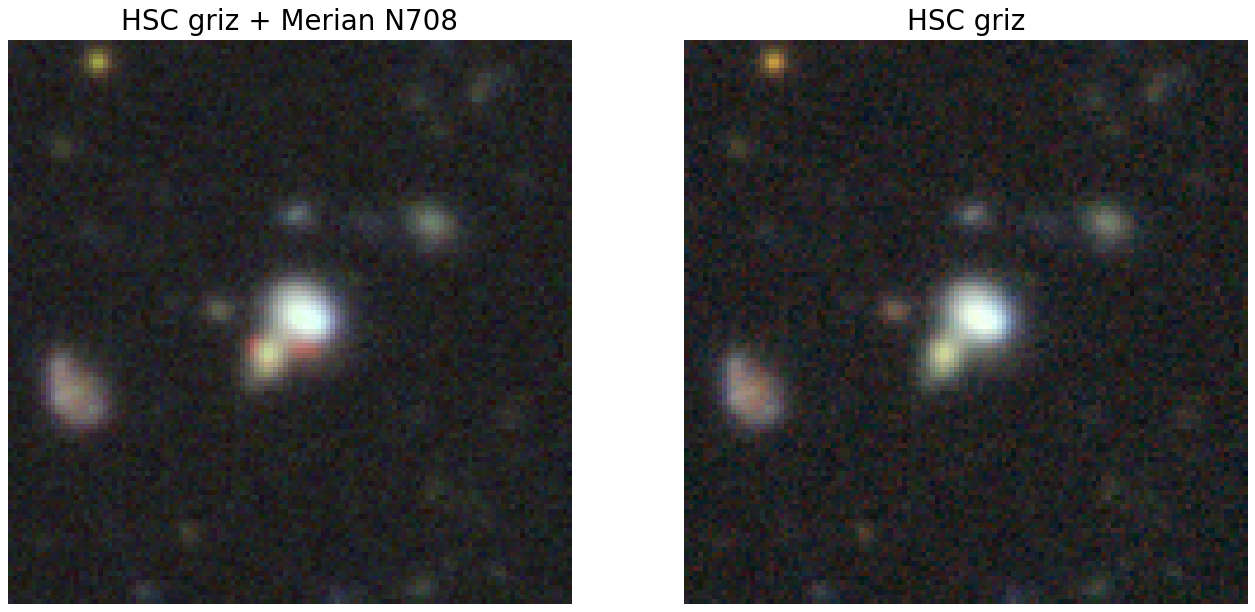

In [184]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))

_img = hsc_data.images
display_merian_cutout_rgb(_img, filters=list('griz') + ['N708', 'N540'], 
                          ax=ax1, color_norm=color_norm, 
                          channel_map=None, N708_strength=1);
ax1.set_title('HSC griz + Merian N708', fontsize=25)

_img = hsc_data.images[0:4]
_, img_rgb = display_merian_cutout_rgb(_img, filters=list('griz'), ax=ax2, 
                                       color_norm=color_norm,
                                       channel_map=None);

ax2.set_title('HSC griz', fontsize=25)

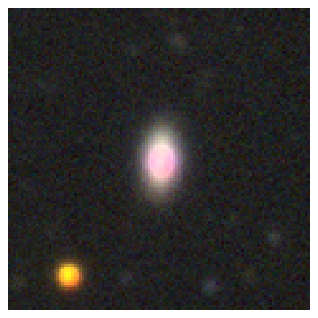

In [150]:
fig, ax = plt.subplots(figsize=(5, 5))

_img = hsc_data.images
display_merian_cutout_rgb(_img, filters=list('griz') + ['N708', 'N540'], 
                          ax=ax, color_norm=color_norm, N708_strength=2.0,
                          channel_map=None);

plt.savefig(f'/tigress/jiaxuanl/public_html/Merian/cutout_RGB/magellan_cosmos_{obj["name"]}_HSC_N708.png', 
            bbox_inches='tight', dpi=70, transparent=True, pad_inches=0)
plt.close()

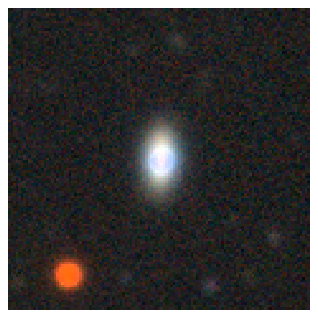

In [151]:
fig, ax = plt.subplots(figsize=(5, 5))

_img = hsc_data.images[:4]
display_merian_cutout_rgb(_img, filters=list('griz'),
                          ax=ax, color_norm=color_norm,
                          channel_map=None);

plt.savefig(f'/tigress/jiaxuanl/public_html/Merian/cutout_RGB/magellan_cosmos_{obj["name"]}_HSC.png', 
            bbox_inches='tight', dpi=70, transparent=True, pad_inches=0)

In [178]:
obj_cat[(obj_cat['redshift'] < 0.12) & (obj_cat['redshift'] > 0.04)][['id', 'ra', 'dec', 'redshift']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_spec/viz_cat_0p04_0p12.txt', 
                                   format='ascii')

In [179]:
obj_cat[['id', 'ra', 'dec', 'redshift']].write('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_spec/viz_cat.txt', 
                                   format='ascii')

In [199]:
# obj_cat[['id', 'ra', 'dec', 'redshift']][:5].write('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_spec/_viz_cat.txt', 
#                                    format='ascii')

In [205]:
obj_cat[np.in1d(obj_cat['id'], [419910, 499315, 504723, 513372, 646134, 691731, 708483]
               )][['id', 'ra', 'dec', 'redshift']].write('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_spec/test_cat.txt', 
                                   format='ascii')

In [163]:
x = np.linspace(3000, 8000, 1000)

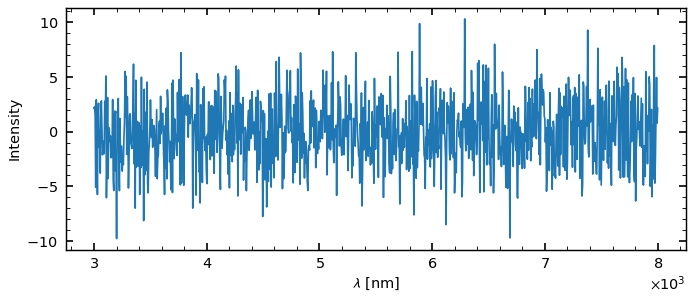

In [170]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(x, np.sin(3*x) + np.random.normal(0, 3, 1000))
plt.xlabel('$\lambda$ [nm]')
plt.ylabel('Intensity')
plt.savefig(f'/tigress/jiaxuanl/public_html/Merian/spectra/magellan_cosmos_296216_spec.png', 
            bbox_inches='tight', dpi=70, transparent=True, pad_inches=0)

In [162]:
len(obj_cat)

759

In [1173]:
# ['g', 'N540', 'r', 'N708', 'i']

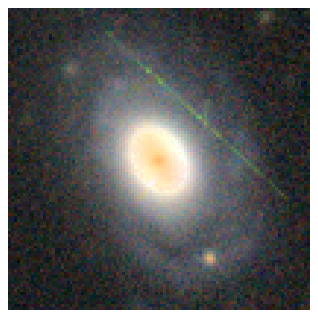

In [1174]:
# images = hsc_data.images
images = np.vstack([hsc_data.images[0:1], hsc_data.images[2:3], hsc_data.images[4:5], hsc_data.images[5:6]])
_, img_rgb = display_merian_cutout_rgb(images, 
                          filters='griz',#channels,
                          color_norm=color_norm);

In [1175]:
# img_rgb[..., 1] = 0
# img_rgb[..., 2] = 0
# plt.imshow(img_rgb)

In [1176]:
gal_merian = mcf.combine_multicolor(
    [img_rgb / 255, color_imgs['N708'] ],
    gamma=1
)

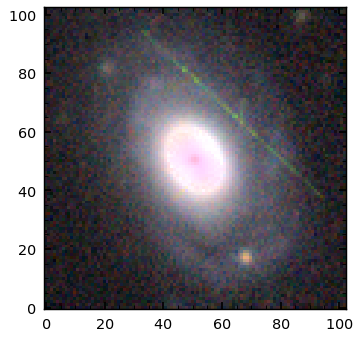

In [1177]:
plt.imshow(gal_merian)

In [976]:
images = np.asarray([hsc_data.images[0], hsc_data.images[2], 
                     hsc_data.images[4], hsc_data.images[5]]) #griz

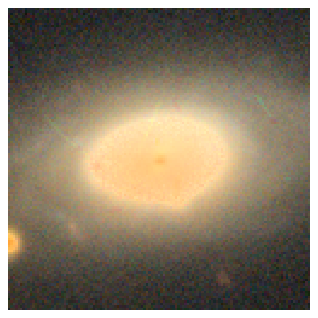

In [977]:
display_merian_cutout_rgb(images, 
                          filters='griz', 
                          color_norm=color_norm);

In [978]:
channels = 'griz'
channel_map = scarlet.display.channels_to_rgb(4)
f_c = np.array([color_norm[filt] for filt in channels])
channel_map = channel_map * f_c[np.newaxis, :]

In [980]:
channel_map

array([[0.        , 0.        , 0.24981245, 0.63765941],
       [0.        , 0.60045011, 0.50037509, 0.        ],
       [1.42535634, 0.29977494, 0.        , 0.        ]])

In [981]:
images.shape

(4, 125, 125)

In [982]:
test = [(channel_map[i][:, np.newaxis, np.newaxis] * images).sum(axis=0) for i in range(3)]

In [983]:
from astropy.visualization.lupton_rgb import AsinhMapping
norm = AsinhMapping(-0.1, 1.5, Q=3)

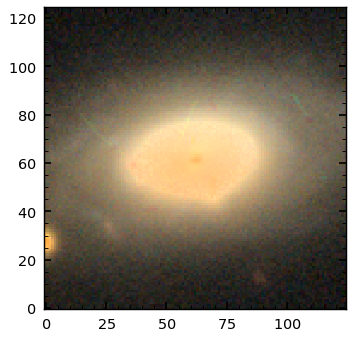

In [984]:
plt.imshow(norm.make_rgb_image(*test))

In [932]:
# a = Q / stretch

In [1018]:
def arcsinh_trans(I, Q=3, stretch=1.2, minimum=-0.15):
    return np.arcsinh((I - minimum) * Q / stretch)# * 0.1 * 1 / np.arcsinh(0.1 * Q)

In [1019]:
vmin, vmax = np.percentile(arcsinh_trans(test[1]), [1, 99])

In [1020]:
vmax

4.338294094270159

In [1021]:
greys = [mcf.greyRGBize_image(arcsinh_trans(test[i]), 
                      rescalefn='asinh', 
                      scaletype='perc', 
                      min_max=[1, 95], 
                      gamma=1, 
                      checkscale=False) for i in range(3)]

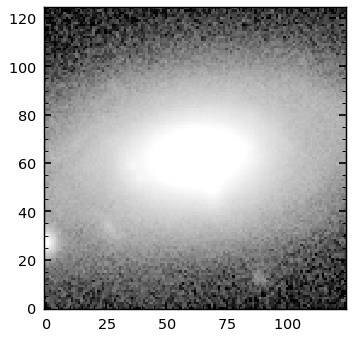

In [1022]:
plt.imshow(greys[0])

In [1023]:
cs = ["#FF0100", "#00FF00", "#0000FF"]

colors = [mcf.colorize_image(greys[i], 
                    cs[i], 
                    colorintype="hex", 
                    gammacorr_color=2.2) for i in range(3)]

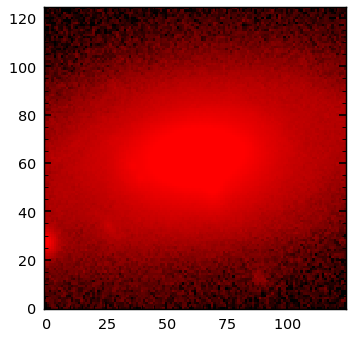

In [1024]:
plt.imshow(colors[0])

In [1025]:
colors[0].shape

(125, 125, 3)

In [1026]:
gal_merian = mcf.combine_multicolor(
    colors,
    gamma=0.9
)

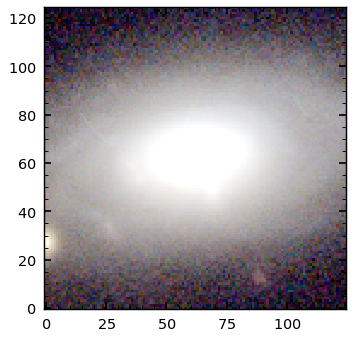

In [1027]:
plt.imshow(gal_merian)

In [592]:
from astropy.visualization import AsinhStretch, LinearStretch

In [ ]:
vmin, vmax = np.percentile(img, percentiles)
stretch = vmax - vmin
Q = stretch / np.sinh(1)

In [572]:
vmin, vmax = np.percentile(test[0], [1, 99])

array([-0.16268655,  0.2347417 ])

In [ ]:
dat_greyRGB = ski_color.gray2rgb(datlinear)

In [590]:
min_max_scale = [1, 99]
gamma = 1

greyRGBs = {}
greyRGBs['R'] = mcf.greyRGBize_image(test[0], 
                                      rescalefn='asinh', 
                                      scaletype='perc', 
                                      min_max=min_max_scale, 
                                      gamma=gamma, 
                                     checkscale=False) 

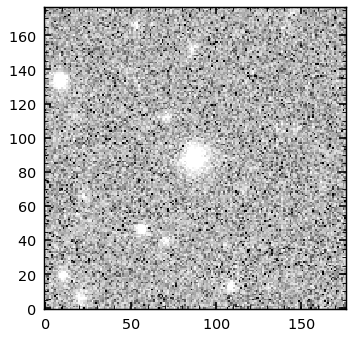

In [591]:
plt.imshow(greyRGBs['R'])

In [ ]:
color_dict = {'g': "#2e0af7", 
              'r': "#07f7eb", 
              'i': "#2beb05", 
              'z': "#f5a105", 
              'y': "#f54905",
              'N708': "#eb5ee4",#"#f01307"
              }

In [ ]:
#Adjust the rescalefn, min_max_scale and gamma to get the best image
#rescalefn: log, linear, sqrt, asinh, squared, etc.
rescalefn = 'asinh'
min_max_scale = [0.01, 99.99]
gamma = 3

greyRGBs = {}
for i, filt in enumerate(channels):
    greyRGBs[filt] = mcf.greyRGBize_image(hsc_data.images[i], 
                                          rescalefn=rescalefn, 
                                          scaletype='perc', 
                                          min_max=min_max_scale, 
                                          gamma=gamma, checkscale=False) 

In [ ]:
gammacorr_color = 10 #- 2

color_imgs = {}
for filt in list('griz') + ['N708']:
    color_imgs[filt] = mcf.colorize_image(greyRGBs[filt], 
                                        color_dict[filt], 
                                        colorintype="hex", 
                                        gammacorr_color=gammacorr_color)

In [ ]:
gal_merian = mcf.combine_multicolor(
    [color_imgs[filt] for filt in ['N708', 'z', 'i', 'r', 'g']], 
    gamma=gammacorr_color
)